# Long Short-Term Memory (LSTM) dengan optimasi Adam

Algoritma Long Short Term Memory (LSTM) adalah turunan istimewa dari Recurrent Neural Network (RNN) yang dirancang untuk mengatasi kelemahan RNN dalam menangani urutan data yang panjang. LSTM memiliki kemampuan untuk menyimpan informasi penting dalam jangka waktu yang lama, membuatnya ideal untuk berbagai aplikasi yang melibatkan data sekuensial.
![image.png](lstm-flow.png)

# A. Menyiapkan Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# B. Memuat Data

In [2]:
data = pd.read_csv('final.csv')
data.head()

,datetime,choke,psig,apsig,oil,gas,water
0,15/5/2021 21:00:00,38,935,320,698.880,4.980,23.616
1,15/5/2021 21:15:00,38,935,321,822.456,4.988,32.592
2,15/5/2021 21:30:00,38,940,318,661.368,5.070,26.208
3,15/5/2021 21:45:00,38,938,317,737.664,5.061,29.232
4,15/5/2021 22:00:00,38,940,319,661.368,5.078,26.208


# C. Pemisahan Data Berdasarkan Nilai Choke
Termasuk menghapus kolom choke karena tidak diperlukan dalam pemodelan

## 1. Berapa choke yang ada dalam data?

In [3]:
data['choke'].value_counts()

choke
38    854
40    645
42    379
Name: count, dtype: int64

## 2. Memisahkan data berdasarkan nilai choke yang ada

In [4]:
data_38 = data[data['choke'] == 38].drop(['datetime', 'choke'], axis=1)
data_40 = data[data['choke'] == 40].drop(['datetime', 'choke'], axis=1)
data_42 = data[data['choke'] == 42].drop(['datetime', 'choke'], axis=1)

# Menampilkan Data
display('Data Choke 38', data_38.describe())
display('Data Choke 40', data_40.describe())
display('Data Choke 42', data_42.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water
count,854.000000,854.000000,854.000000,854.000000,854.000000
mean,1007.033958,325.594848,761.594501,5.987358,17.394857
std,73.533621,7.364072,45.464697,0.562406,7.202383
min,835.000000,304.000000,610.704000,4.745000,6.144000
25%,934.250000,320.000000,733.080000,5.279250,14.976000
50%,1050.000000,328.000000,757.560000,6.267000,16.512000
75%,1054.000000,331.000000,788.448000,6.384000,22.704000
max,1067.000000,340.000000,893.448000,6.579000,48.000000


'Data Choke 40'

,psig,apsig,oil,gas,water
count,645.000000,645.000000,645.000000,645.000000,645.000000
mean,1021.804651,331.893023,767.669991,7.038047,15.788130
std,5.367747,5.293207,27.692167,0.059675,3.047829
min,1004.000000,318.000000,712.440000,6.888000,7.872000
25%,1018.000000,327.000000,747.168000,7.000000,15.936000
50%,1022.000000,334.000000,765.216000,7.038000,16.512000
75%,1026.000000,336.000000,786.792000,7.077000,16.896000
max,1039.000000,340.000000,839.832000,7.230000,31.920000


'Data Choke 42'

,psig,apsig,oil,gas,water
count,379.000000,379.000000,379.000000,379.000000,379.000000
mean,988.068602,326.704485,800.717636,7.557427,17.555208
std,4.861635,2.377642,16.509230,0.066787,1.365055
min,982.000000,320.000000,757.224000,7.292000,9.024000
25%,985.000000,325.000000,790.080000,7.544500,17.280000
50%,986.000000,327.000000,800.400000,7.575000,17.472000
75%,990.000000,328.000000,815.568000,7.599000,17.856000
max,1018.000000,333.000000,845.280000,7.673000,27.072000


# D. Normalisasi Data

## 1. Membuat fungsi untuk normalisasi data

In [5]:
def normalize_dataframe(df):
    # Normalisasi Data metode Min-Max
    # df: DataFrame
    # return: DataFrame yang sudah dinormalisasi

    assert isinstance(df, pd.DataFrame), 'df harus bertipe DataFrame'

    # Membuat salinan DataFrame
    df_normalized = df.copy()
    
    #  Iterasi setiap kolom dalam DataFrame
    for column in df.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df[column].min()
        max_value = df[column].max()
        
        # Normalisasi setiap nilai dalam kolom
        df_normalized[column] = (df[column] - min_value) / (max_value - min_value)
    return df_normalized

## 2. Menormalisasi Data

In [6]:
data_38_normalized = normalize_dataframe(data_38)
data_40_normalized = normalize_dataframe(data_40)
data_42_normalized = normalize_dataframe(data_42)

# Menampilkan Data
display('Data Choke 38', data_38_normalized.describe())
display('Data Choke 40', data_40_normalized.describe())
display('Data Choke 42', data_42_normalized.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water
count,854.000000,854.000000,854.000000,854.000000,854.000000
mean,0.741526,0.599857,0.533665,0.677404,0.268799
std,0.316955,0.204558,0.160798,0.306656,0.172075
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.427802,0.444444,0.432816,0.291303,0.211009
50%,0.926724,0.666667,0.519396,0.829880,0.247706
75%,0.943966,0.750000,0.628639,0.893675,0.395642
max,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 40'

,psig,apsig,oil,gas,water
count,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.508704,0.631501,0.433544,0.438732,0.329180
std,0.153364,0.240600,0.217378,0.174488,0.126739
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.409091,0.272607,0.327485,0.335329
50%,0.514286,0.727273,0.414280,0.438596,0.359281
75%,0.628571,0.818182,0.583647,0.552632,0.375250
max,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 42'

,psig,apsig,oil,gas,water
count,379.000000,379.000000,379.000000,379.000000,379.000000
mean,0.168572,0.515730,0.493932,0.696660,0.472696
std,0.135045,0.182896,0.187486,0.175294,0.075635
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.083333,0.384615,0.373126,0.662730,0.457447
50%,0.111111,0.538462,0.490324,0.742782,0.468085
75%,0.222222,0.615385,0.662578,0.805774,0.489362
max,1.000000,1.000000,1.000000,1.000000,1.000000


# E. Mengubah Data Series Menjadi Data Supervised

## 1. Membuat Fungsi untuk Membuat Data Supervised

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## 2. Menggunakan Fungsi untuk Membuat Data Supervised

In [8]:
supervised_38 = series_to_supervised(data_38_normalized, 1, 1)
supervised_40 = series_to_supervised(data_40_normalized, 1, 1)
supervised_42 = series_to_supervised(data_42_normalized, 1, 1)

# Menampilkan Data
display('Data Choke 38', supervised_38.head())
display('Data Choke 40', supervised_40.head())
display('Data Choke 42', supervised_42.head())

'Data Choke 38'

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.431034,0.444444,0.311858,0.128135,0.417431,0.431034,0.472222,0.748918,0.132497,0.631881
2,0.431034,0.472222,0.748918,0.132497,0.631881,0.452586,0.388889,0.179187,0.177208,0.479358
3,0.452586,0.388889,0.179187,0.177208,0.479358,0.443966,0.361111,0.449028,0.172301,0.551606
4,0.443966,0.361111,0.449028,0.172301,0.551606,0.452586,0.416667,0.179187,0.181570,0.479358
5,0.452586,0.416667,0.179187,0.181570,0.479358,0.461207,0.416667,0.359138,0.181570,0.527523


'Data Choke 40'

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
855,0.000000,0.772727,0.652977,0.450292,0.391218,0.200000,0.909091,0.652977,0.543860,0.391218
856,0.200000,0.909091,0.652977,0.543860,0.391218,0.257143,0.818182,0.557460,0.479532,0.930140
857,0.257143,0.818182,0.557460,0.479532,0.930140,0.400000,0.727273,0.899020,0.652047,1.000000
858,0.400000,0.727273,0.899020,0.652047,1.000000,0.457143,1.000000,0.759231,1.000000,0.590818
859,0.457143,1.000000,0.759231,1.000000,0.590818,0.400000,1.000000,0.899020,0.921053,1.000000


'Data Choke 42'

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1500,1.000000,0.615385,0.496321,0.183727,0.968085,0.916667,0.461538,0.895884,0.123360,0.000000
1501,0.916667,0.461538,0.895884,0.123360,0.000000,0.833333,0.384615,0.996729,0.091864,0.005319
1502,0.833333,0.384615,0.996729,0.091864,0.005319,0.722222,0.153846,0.948487,0.000000,0.257979
1503,0.722222,0.153846,0.948487,0.000000,0.257979,0.777778,0.384615,1.000000,0.091864,0.521277
1504,0.777778,0.384615,1.000000,0.091864,0.521277,0.666667,0.153846,0.899973,0.104987,0.510638


# F. Membagi Data Menjadi Data Training dan Data Testing

In [9]:
train_ratio = 0.8

train_38_X = supervised_38.iloc[:int(len(supervised_38) * train_ratio), :5]
train_38_y = supervised_38.iloc[:int(len(supervised_38) * train_ratio), 5:]
test_38_X = supervised_38.iloc[int(len(supervised_38) * train_ratio):, :5]
test_38_y = supervised_38.iloc[int(len(supervised_38) * train_ratio):, 5:]

train_40_X = supervised_40.iloc[:int(len(supervised_40) * train_ratio), :5]
train_40_y = supervised_40.iloc[:int(len(supervised_40) * train_ratio), 5:]
test_40_X = supervised_40.iloc[int(len(supervised_40) * train_ratio):, :5]
test_40_y = supervised_40.iloc[int(len(supervised_40) * train_ratio):, 5:]

train_42_X = supervised_42.iloc[:int(len(supervised_42) * train_ratio), :5]
train_42_y = supervised_42.iloc[:int(len(supervised_42) * train_ratio), 5:]
test_42_X = supervised_42.iloc[int(len(supervised_42) * train_ratio):, :5]
test_42_y = supervised_42.iloc[int(len(supervised_42) * train_ratio):, 5:]

# G. Membangun Model LSTM

In [10]:
import numpy as np

class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        # Menginisialisasi ukuran input, hidden, dan output
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Menginisialisasi weights dan biases untuk forget gate
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size) * np.sqrt(2 / (hidden_size + input_size))
        self.bf = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk input gate
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size) * np.sqrt(2 / (hidden_size + input_size))
        self.bi = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk cell gate
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size) * np.sqrt(2 / (hidden_size + input_size))
        self.bc = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk output gate
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size) * np.sqrt(2 / (hidden_size + input_size))
        self.bo = np.zeros((hidden_size, 1))

        # Menginisialisasi weights dan biases untuk output layer
        self.Wy = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size)
        self.by = np.zeros((output_size, 1))

        # Menginisialisasi m dan v untuk Adam optimizer
        self.m = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}
        self.v = {k: np.zeros_like(v) for k, v in self.__dict__.items() if isinstance(v, np.ndarray)}
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0

        # loss history
        self.loss_history = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x, h_prev, C_prev):
        assert h_prev.shape == (self.hidden_size, 1)
        assert x.shape == (self.input_size, 1)
        assert C_prev.shape == (self.hidden_size, 1)

        combined = np.concatenate((h_prev, x), axis=0)

        ft = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
        it = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
        Ct_hat = self.tanh(np.dot(self.Wc, combined) + self.bc)
        Ct = ft * C_prev + it * Ct_hat
        ot = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
        ht = ot * self.tanh(Ct)
        yt = np.dot(self.Wy, ht) + self.by

        assert yt.shape == (self.output_size, 1)
        assert ht.shape == (self.hidden_size, 1)
        assert Ct.shape == (self.hidden_size, 1)

        return yt, ht, Ct

    def update_parameters(self, grads, learning_rate):
        self.t += 1
        for key in grads:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            
            self.__dict__[key] -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def train(self, X, Y, epochs=1000, learning_rate=0.001):
        m, _ = X.shape
        _, _ = Y.shape

        h_prev = np.zeros((self.hidden_size, 1)) if not hasattr(self, 'h_prev') else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if not hasattr(self, 'C_prev') else self.C_prev

        for epoch in range(epochs):
            loss = 0

            for t in range(m):
                x = X[t].reshape(-1, 1)
                y_true = Y[t].reshape(-1, 1)
                y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)

                self.h_prev = h_prev
                self.C_prev = C_prev

                dy = y_pred - y_true

                dWy = np.dot(dy, h_prev.T)
                dby = dy
                dh = np.dot(self.Wy.T, dy)
                dC = dh * self.tanh(C_prev) * (1 - self.tanh(C_prev))

                do = dh * self.tanh(C_prev)
                dWo = np.dot(do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo)), np.concatenate((h_prev, x), axis=0).T)
                dbo = do * self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo) * (1 - self.sigmoid(np.dot(self.Wo, np.concatenate((h_prev, x), axis=0)) + self.bo))

                dC_bar = dC * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)
                dWc = np.dot(dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2), np.concatenate((h_prev, x), axis=0).T)
                dbc = dC_bar * (1 - self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc) ** 2)

                di = dC * self.tanh(np.dot(self.Wc, np.concatenate((h_prev, x), axis=0)) + self.bc)
                dWi = np.dot(di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi)), np.concatenate((h_prev, x), axis=0).T)
                dbi = di * self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi) * (1 - self.sigmoid(np.dot(self.Wi, np.concatenate((h_prev, x), axis=0)) + self.bi))

                df = dC * C_prev
                dWf = np.dot(df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf)), np.concatenate((h_prev, x), axis=0).T)
                dbf = df * self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf) * (1 - self.sigmoid(np.dot(self.Wf, np.concatenate((h_prev, x), axis=0)) + self.bf))

                grads = {'Wy': dWy, 'by': dby, 'Wo': dWo, 'bo': dbo, 'Wc': dWc, 'bc': dbc, 'Wi': dWi, 'bi': dbi, 'Wf': dWf, 'bf': dbf}

                self.update_parameters(grads, learning_rate)

                loss += np.sum((y_true - y_pred) ** 2) / 2

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss / m}', end='\r')
            self.loss_history.append(loss / m)

    def predict(self, X):
        m, _ = X.shape
        predictions = np.zeros((m, self.output_size))

        h_prev = np.zeros((self.hidden_size, 1)) if not hasattr(self, 'h_prev') else self.h_prev
        C_prev = np.zeros((self.hidden_size, 1)) if not hasattr(self, 'C_prev') else self.C_prev

        for t in range(m):
            x = X[t].reshape(-1, 1)
            y_pred, h_prev, C_prev = self.forward(x, h_prev, C_prev)
            predictions[t] = y_pred.flatten()

        return predictions

    def evaluate(self, X, Y):
        predictions = self.predict(X)
        mse = np.mean((Y - predictions) ** 2)
        rmse = np.sqrt(mse)
        return mse, rmse
    
    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

# H. Melatih Model

## 1. Menentukan Hyperparameter

In [11]:
model_38 = LSTM(input_size=5, hidden_size=400, output_size=5)
model_40 = LSTM(input_size=5, hidden_size=400, output_size=5)
model_42 = LSTM(input_size=5, hidden_size=400, output_size=5)

## 2. Melatih Model

In [12]:
model_38.train(train_38_X.values, train_38_y.values, epochs=100, learning_rate=0.01)
model_40.train(train_40_X.values, train_40_y.values, epochs=100, learning_rate=0.01)
model_42.train(train_42_X.values, train_42_y.values, epochs=100, learning_rate=0.01)

## 3. Melihat Grafik Loss

Loss Choke 38

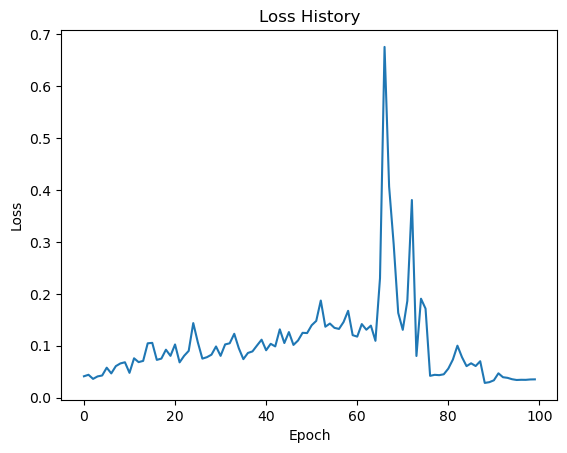

In [13]:
model_38.plot_loss()

Loss Choke 40

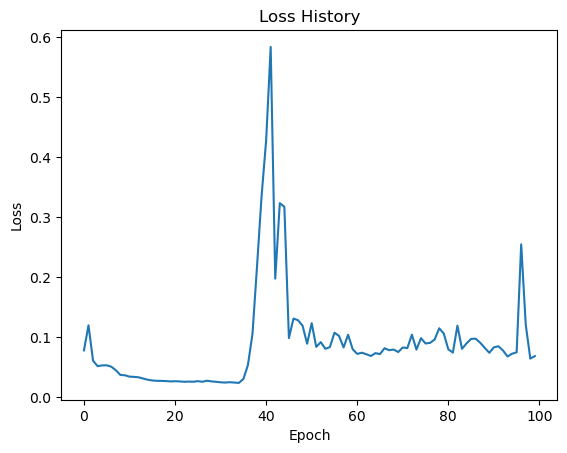

In [14]:
model_40.plot_loss()

Loss Choke 42

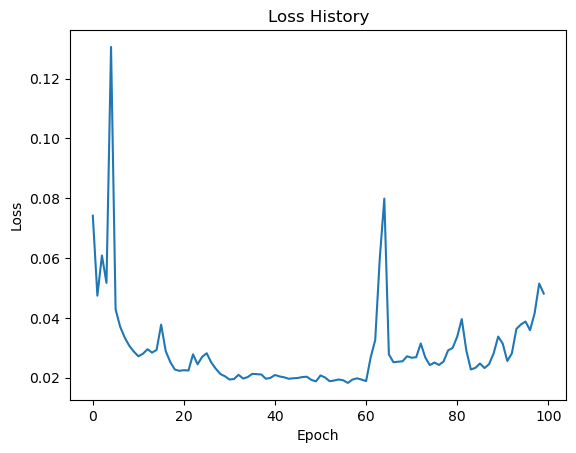

In [15]:
model_42.plot_loss()

# I. Evaluasi Model

In [16]:
mse_38, rmse_38 = model_38.evaluate(test_38_X.values, test_38_y.values)
mse_40, rmse_40 = model_40.evaluate(test_40_X.values, test_40_y.values)
mse_42, rmse_42 = model_42.evaluate(test_42_X.values, test_42_y.values)

print(f'MSE Choke 38: {mse_38}, RMSE Choke 38: {rmse_38}')
print(f'MSE Choke 40: {mse_40}, RMSE Choke 40: {rmse_40}')
print(f'MSE Choke 42: {mse_42}, RMSE Choke 42: {rmse_42}')

MSE Choke 38: 0.012151048884673284, RMSE Choke 38: 0.11023179616006121
MSE Choke 40: 0.06338341624766436, RMSE Choke 40: 0.2517606328393388
MSE Choke 42: 0.01588301157684371, RMSE Choke 42: 0.1260278206462514


# J. Prediksi Data Testing

In [17]:
predictions_38 = model_38.predict(test_38_X.values)
predictions_40 = model_40.predict(test_40_X.values)
predictions_42 = model_42.predict(test_42_X.values)

# K. Denormalisasi Data

## 1. Membuat Fungsi untuk Denormalisasi Data

In [18]:
def denormalize_dataframe(np_normalized, df_original):
    # Denormalisasi DataFrame menggunakan metode Min-Max
    # np_normalized: numpy array yang sudah dinormalisasi
    # df_original: DataFrame asli sebelum dinormalisasi
    # return: DataFrame yang sudah denormalisasi

    assert isinstance(df_original, pd.DataFrame), 'df_original harus bertipe DataFrame'
    assert isinstance(np_normalized, np.ndarray), 'np_normalized harus bertipe numpy array'

    # Membuat salinan DataFrame yang sudah dinormalisasi
    df_normalized = pd.DataFrame(np_normalized, columns=df_original.columns)
    
    # Iterasi setiap kolom dalam DataFrame
    for column in df_normalized.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df_original[column].min()
        max_value = df_original[column].max()
        
        # Denormalisasi setiap nilai dalam kolom
        df_normalized[column] = df_normalized[column] * (max_value - min_value) + min_value
        
    return df_normalized

## 2. Denormalisasi Data

In [19]:
denormalized_predictions_38 = denormalize_dataframe(predictions_38, data_38)
denormalized_predictions_40 = denormalize_dataframe(predictions_40, data_40)
denormalized_predictions_42 = denormalize_dataframe(predictions_42, data_42)

denormalized_test_38_y = denormalize_dataframe(test_38_y.values, data_38)
denormalized_test_40_y = denormalize_dataframe(test_40_y.values, data_40)
denormalized_test_42_y = denormalize_dataframe(test_42_y.values, data_42)

denormalized_train_38_y = denormalize_dataframe(train_38_y.values, data_38)
denormalized_train_40_y = denormalize_dataframe(train_40_y.values, data_40)
denormalized_train_42_y = denormalize_dataframe(train_42_y.values, data_42)

# L. Visualisasi Data

## 1. Data Choke 38

/tmp/ipykernel_38939/716829282.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


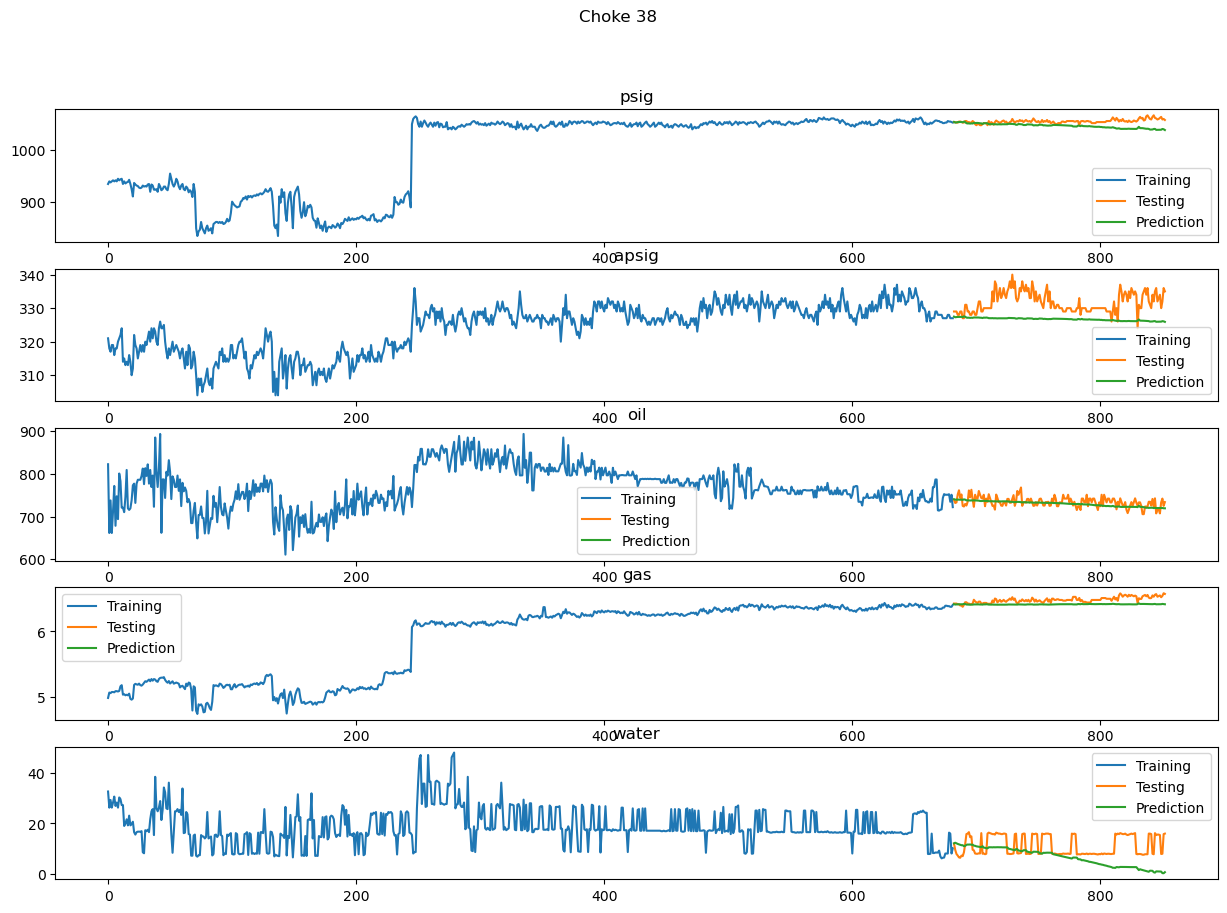

In [20]:
fig, axes = plt.subplots(figsize=(15, 10), nrows=denormalized_train_38_y.shape[1])

for i, ax in enumerate(axes):
    ax.plot(list(range(denormalized_train_38_y.shape[0])), denormalized_train_38_y.iloc[:, i], label='Training')
    ax.plot(list(range(denormalized_train_38_y.shape[0], denormalized_train_38_y.shape[0] + denormalized_test_38_y.shape[0])), denormalized_test_38_y.iloc[:, i], label='Testing')
    ax.plot(list(range(denormalized_train_38_y.shape[0], denormalized_train_38_y.shape[0] + denormalized_test_38_y.shape[0])), denormalized_predictions_38.iloc[:, i], label='Prediction')
    ax.set_title(denormalized_train_38_y.columns[i])
    ax.legend()

fig.suptitle('Choke 38')
fig.savefig('choke_38.png')
fig.show()

## Data Choke 40

/tmp/ipykernel_38939/291444122.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


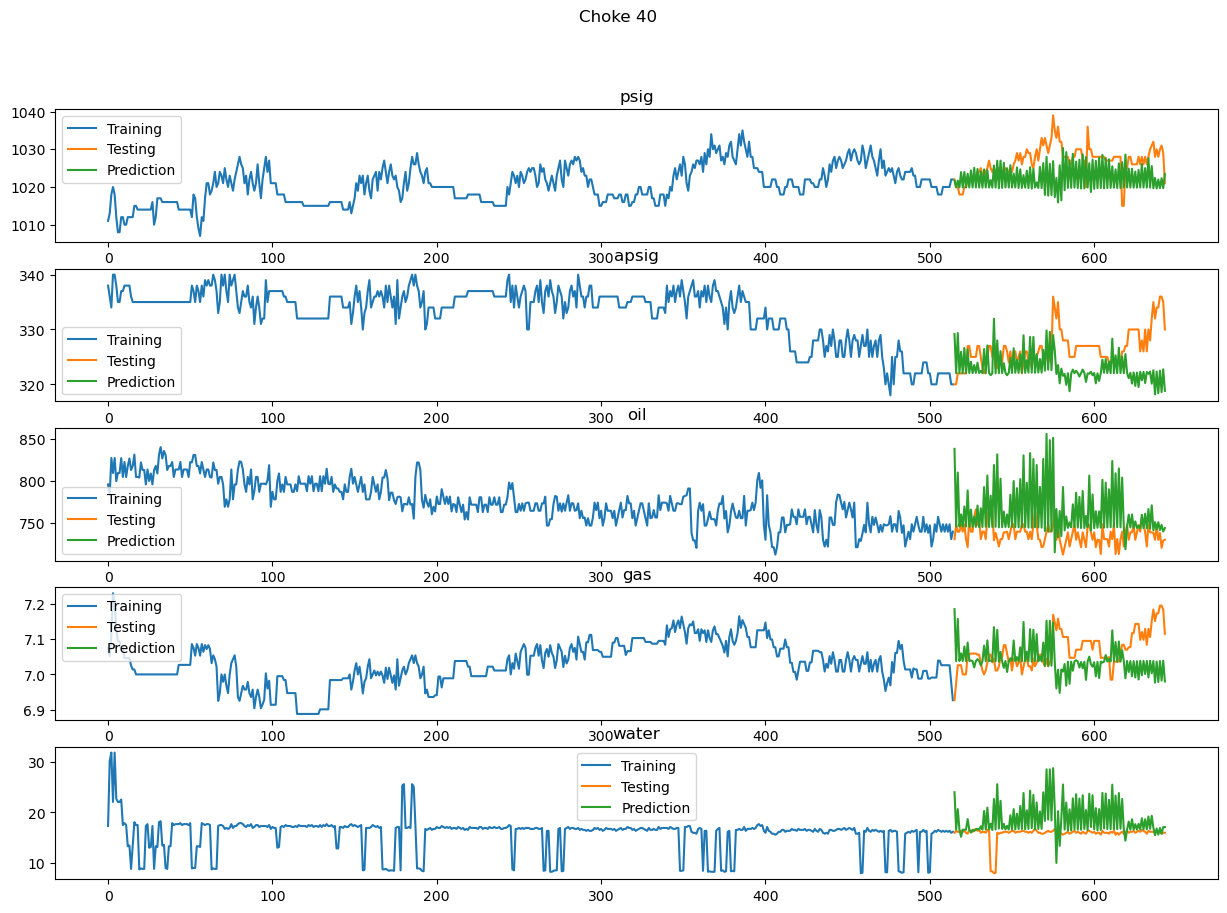

In [21]:
fig, axes = plt.subplots(figsize=(15, 10), nrows=denormalized_train_40_y.shape[1])

for i, ax in enumerate(axes):
    ax.plot(list(range(denormalized_train_40_y.shape[0])), denormalized_train_40_y.iloc[:, i], label='Training')
    ax.plot(list(range(denormalized_train_40_y.shape[0], denormalized_train_40_y.shape[0] + denormalized_test_40_y.shape[0])), denormalized_test_40_y.iloc[:, i], label='Testing')
    ax.plot(list(range(denormalized_train_40_y.shape[0], denormalized_train_40_y.shape[0] + denormalized_test_40_y.shape[0])), denormalized_predictions_40.iloc[:, i], label='Prediction')
    ax.set_title(denormalized_train_40_y.columns[i])
    ax.legend()

fig.suptitle('Choke 40')
fig.savefig('choke_40.png')
fig.show()

## Data Choke 42

/tmp/ipykernel_38939/2959978377.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


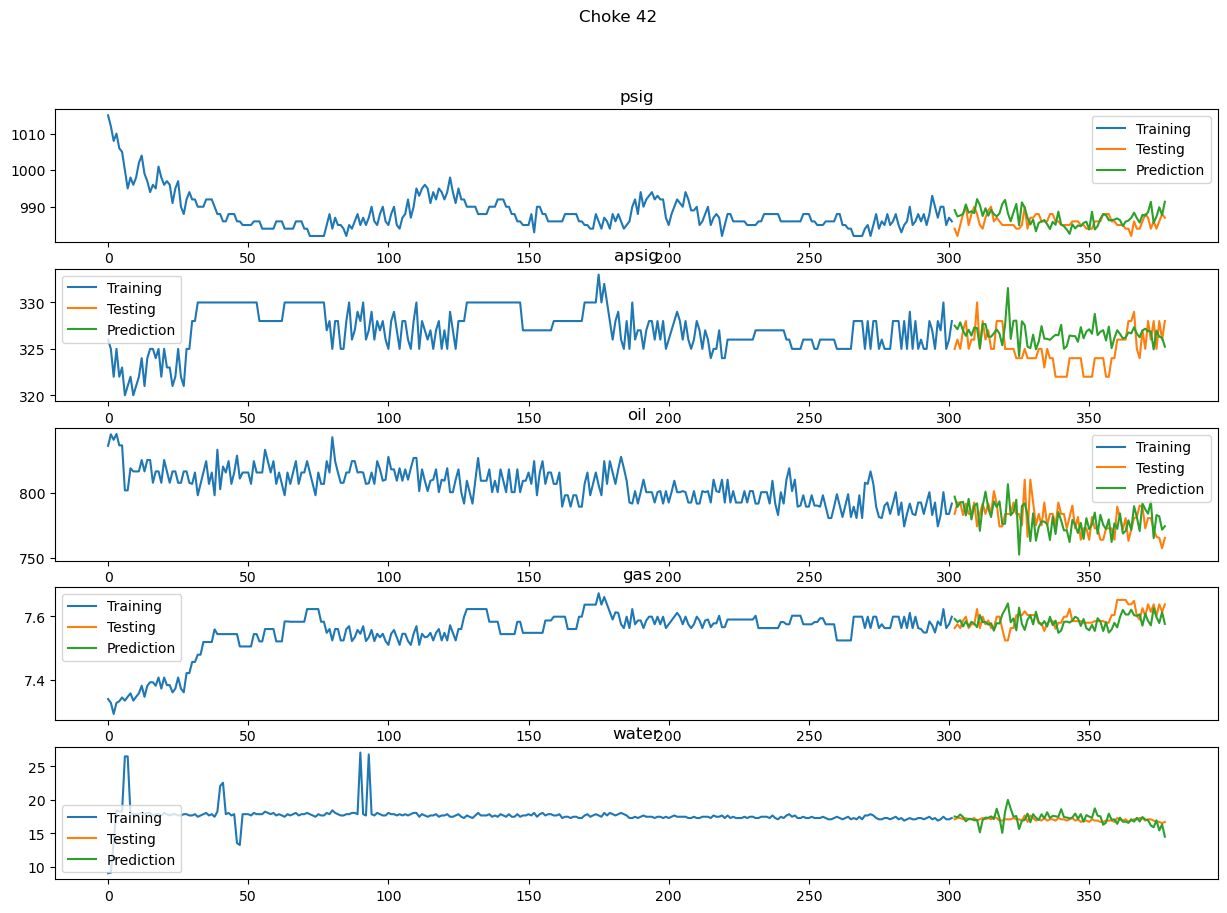

In [22]:
fig, axes = plt.subplots(figsize=(15, 10), nrows=denormalized_train_42_y.shape[1])

for i, ax in enumerate(axes):
    ax.plot(list(range(denormalized_train_42_y.shape[0])), denormalized_train_42_y.iloc[:, i], label='Training')
    ax.plot(list(range(denormalized_train_42_y.shape[0], denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0])), denormalized_test_42_y.iloc[:, i], label='Testing')
    ax.plot(list(range(denormalized_train_42_y.shape[0], denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0])), denormalized_predictions_42.iloc[:, i], label='Prediction')
    ax.set_title(denormalized_train_42_y.columns[i])
    ax.legend()

fig.suptitle('Choke 42')
fig.savefig('choke_42.png')
fig.show()